In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import statsmodels
import time
import missingno as msno
%matplotlib inline

# <a name="top"></a> Recommender System for Microloan Contributers:
## A Study of the Kiva Dataset

### Project Contents:
|Name|Description|
|---|---|
|01_EDA_&_Cleaning|Provides an introduction to the project, including problem statement and background, and the code to perform initial cleaning of the non-NLP data for modeling.|
|02_Preprocessing|Processes NLP data for visualizations and modeling.|
|03_Modeling|Builds a content based recommender system.|
|04_User_Model|Builds a user based recommender system for groups.|
|05_Data_Visualizations|Explores the data through visualizations|




You are currently in the notebook 05_Data_Visualizations

### Notebook Table of Contents

* [Initial Exploratory Data Analysis](#eda)
* [Cleaning Data for Visualizations](#cleaning)
* [Loans by Lenders](#lenders)
* [Loans by Sector](#sectorall)
    * [Loans by Country and Sector (countries with over 5000 loans total)](#sectorcountry)
    * [Entertainment and Wholesale Sector Loans (Sectors with the Fewest Loans)](#entertainment)
    * [Agriculture and Food Sector Loans (Sectors with the Most Loans)](#agfood)
* [Gender Analysis](#genderanalysis)
    * [The ten countries representing the highest percentage of loans to female operated endeavors](#10female) 
    * [Female operated endeavors by sector](#sectorfemale)
    * [Loans in Countries Ranked Lowest for Women's Peace and Security](#women)
* [Loan Activity Over Time](#time)
* [Prepare Data for Streamlit Visualizations](#streamlit)


In [2]:
# reading in the loans dataset.

loans_df = pd.read_csv("../data/raw/loans.csv")

In [3]:
# Sort DataFrame into Most Recent Loans on Top 
loans_df = loans_df.sort_values(by=['POSTED_TIME'], ascending=False)

In [4]:
#setting a color palette for visualizations
colors = "gist_earth_r"
sns.set_palette(sns.color_palette(colors))

### <a name="eda"></a>  Initial EDA

[Jump to the top of the page](#top)

#### Look at Missing Values Across Time - Oldest Loans on the Bottom

<AxesSubplot:>

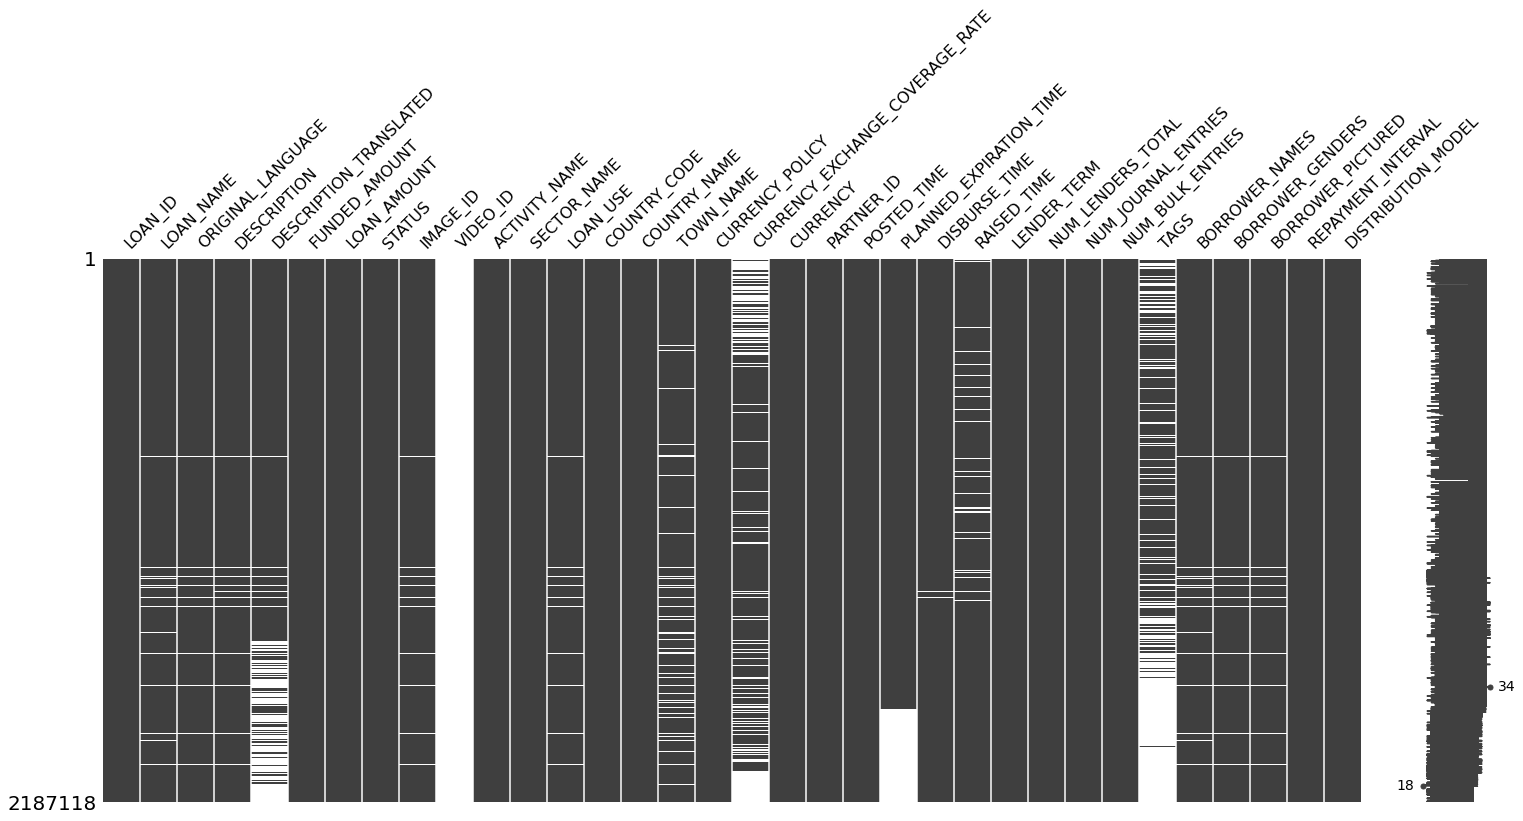

In [5]:
msno.matrix(loans_df)

#### Examining Total Loans Funded & Money Distribution Methods

95% of all loans are funded. 

direct loans are only currently available to lendees located in the United States. Lendees in all other countries receive loans by way of a field partner. Read more about field partners on Kiva's website: https://www.kiva.org/about/how#faq-hkw-section

In [6]:
loans_df['STATUS'].value_counts(normalize=True)

funded         0.950358
expired        0.042721
refunded       0.004265
fundRaising    0.002656
Name: STATUS, dtype: float64

In [7]:
loans_df['DISTRIBUTION_MODEL'].value_counts(normalize=True)

field_partner    0.989939
direct           0.010061
Name: DISTRIBUTION_MODEL, dtype: float64

#### Language Distribution Across Borrowers

[Jump to the top of the page](#top)

In [8]:
loans_df.ORIGINAL_LANGUAGE.value_counts()

English       1482820
Spanish        472437
French         112706
Russian         57955
Portuguese      11849
Vietnamese       1965
Indonesian       1003
Arabic            343
Name: ORIGINAL_LANGUAGE, dtype: int64

#### Loan Amount Analysis

In [9]:
#minimum loan amount
loans_df.LOAN_AMOUNT.min()

25.0

In [10]:
#maxiumum loan amount
loans_df.LOAN_AMOUNT.max()

500000.0

#### Comparing Posted Time vs. Disburse Time

The average time that elapses between the date that a loan is posted on the website and the date that the loan is disbursed is 14 days. 

In [11]:
df_time = loans_df[['POSTED_TIME', 'DISBURSE_TIME']]

df_time = df_time.apply(pd.to_datetime)

In [12]:
df_time.isna().sum()

POSTED_TIME         0
DISBURSE_TIME    4274
dtype: int64

In [13]:
df_time = df_time.dropna()
df_time = df_time.reset_index(drop=True)
df_time.isna().sum()

POSTED_TIME      0
DISBURSE_TIME    0
dtype: int64

In [14]:
df_time['TIME_DIFF'] = df_time['DISBURSE_TIME'] - df_time['POSTED_TIME']
df_time.TIME_DIFF.mean()

Timedelta('-14 days +13:34:11.996620465')

In [15]:
df_time.dtypes

POSTED_TIME      datetime64[ns, UTC]
DISBURSE_TIME    datetime64[ns, UTC]
TIME_DIFF            timedelta64[ns]
dtype: object

In [16]:
#converting time_diff to just number of days - https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe
df_time['TIME_DIFF'] = df_time['TIME_DIFF'].dt.days

In [17]:
df_time.dtypes

POSTED_TIME      datetime64[ns, UTC]
DISBURSE_TIME    datetime64[ns, UTC]
TIME_DIFF                      int64
dtype: object

In [18]:
df_time.TIME_DIFF.min()

-368

In [19]:
#seems to be an outlier or incorrect data - Loan disbursement came 1 year and a half after being posted
df_time.TIME_DIFF.max()

539

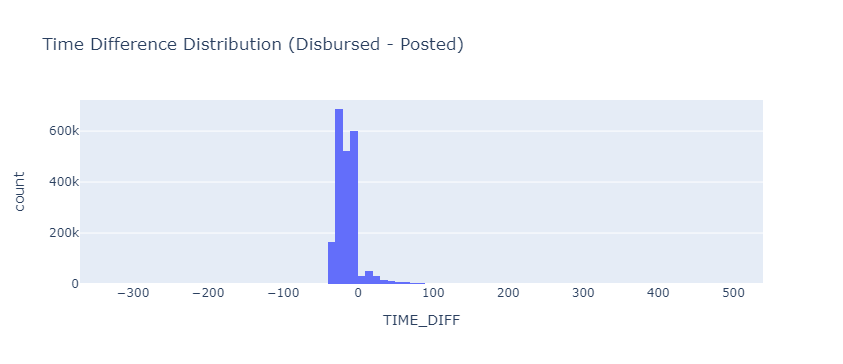

In [20]:
import plotly.express as px
time_diff = px.histogram(data_frame=df_time, x="TIME_DIFF", nbins=100, title='Time Difference Distribution (Disbursed - Posted)')
#time_diff is a plotly interactive graph object - used the built in save to png feature 

#displaying saved png file from plotly graph to reduce notebook file size- https://stackoverflow.com/questions/11854847/how-can-i-display-an-image-from-a-file-in-jupyter-notebook
from IPython.display import Image
Image(filename='../images/time_diff.png') 

In [21]:
X = df_time[df_time["TIME_DIFF"] > 0]  #filter on loans where disbursement made after posted time
Y = df_time[df_time["TIME_DIFF"] < 0]  #filter on loans where disbursement made before posted time
print(X["TIME_DIFF"].shape)  # number of disbursement made after posted time
print(Y["TIME_DIFF"].shape)  # number of disbursement made before posted time

(167552,)
(2006863,)


According to Kiva's website, field partners have the option to distribute loans before, during, or after a loan is posted on the site. 93% of loans are disbursed before they are even posted. Read more about this process on Kiva's site: https://www.kiva.org/about/how#faq-hkw-section

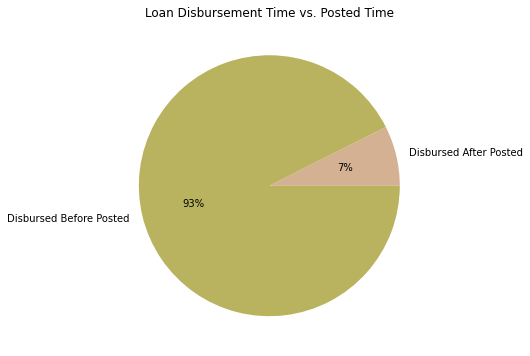

In [22]:
data = [158235, 1971964]
labels = ['Disbursed After Posted', 'Disbursed Before Posted']

#create pie chart
plt.figure(figsize=(6,6))
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.title('Loan Disbursement Time vs. Posted Time')
plt.show()

### <a name="cleaning"></a>  Cleaning Data for Visualizations

[Jump to the top of the page](#top)

In [23]:
#function to prepare non-NLP data for data visualizations. 

def clean_loans_df_for_viz(df = loans_df):
    
    #dropping nulls banded by time in BORROWER_GENDERS, LOAN_USE, ORIGINAL_LANGUAGE
    df = df.drop(df[df["BORROWER_GENDERS"].isnull()].index)
    df = df.drop(df[df["LOAN_USE"].isnull()].index)
    df = df.drop(df[df["DESCRIPTION"].isnull()].index)
    df['ORIGINAL_LANGUAGE'].dropna(inplace=True)
    
    #BORROWER_GENDERS - create a column indicating if a loan is for a solely female owned/operated endeavor
    df['BORROWER_GENDERS'] = df['BORROWER_GENDERS'].str.split(', ')
    df['FEMALE_OPERATED'] = [1 if 'male' not in gen_list else 0 for gen_list in df['BORROWER_GENDERS'] ]
    
    #Formatting Posted_Time column to include only Year, Month, Day
    df['POSTED_TIME'] = [i[:10] for i in df['POSTED_TIME']]
    
    #drop columns not needed for viz
    df.drop(columns = ['DESCRIPTION', 'DESCRIPTION_TRANSLATED', 'LOAN_NAME', 'FUNDED_AMOUNT', 'STATUS', 
                       'IMAGE_ID', 'VIDEO_ID', 'COUNTRY_CODE', 'CURRENCY_POLICY',
                       'CURRENCY_EXCHANGE_COVERAGE_RATE', 'CURRENCY', 'PLANNED_EXPIRATION_TIME', 'LENDER_TERM',
                       'NUM_BULK_ENTRIES', 'BORROWER_NAMES', 'BORROWER_PICTURED', 'REPAYMENT_INTERVAL',
                       'DISTRIBUTION_MODEL', 'NUM_JOURNAL_ENTRIES', 'LOAN_USE'], inplace=True)
    
    return df
            
    
viz_loans_df = clean_loans_df_for_viz(df = loans_df)   

In [24]:
#Formula to get top ten lists. 

def get_ten_and_sort(df):
    #get top ten by value counts
    top_10_values = df['COUNTRY_NAME'].value_counts().to_frame()[:10]
    df = df[df['COUNTRY_NAME'].isin(top_10_values.index)]
    
    #I consultated stackoverflow for this code: https://stackoverflow.com/questions/51829419/how-to-sort-a-pandas-data-frame-by-value-counts-of-a-column
    #sort dataframe by value counts
    df.iloc[df.groupby('COUNTRY_NAME').COUNTRY_NAME.transform('size').argsort(kind='mergesort')]
    i, r = pd.factorize(df['COUNTRY_NAME'])
    a = np.argsort(np.bincount(i)[i], kind='mergesort')
    df=df.iloc[a]
    
    return df

In [25]:
viz_loans_df.columns

Index(['LOAN_ID', 'ORIGINAL_LANGUAGE', 'LOAN_AMOUNT', 'ACTIVITY_NAME',
       'SECTOR_NAME', 'COUNTRY_NAME', 'TOWN_NAME', 'PARTNER_ID', 'POSTED_TIME',
       'DISBURSE_TIME', 'RAISED_TIME', 'NUM_LENDERS_TOTAL', 'TAGS',
       'BORROWER_GENDERS', 'FEMALE_OPERATED'],
      dtype='object')

In [26]:
viz_loans_df.isna().sum()

LOAN_ID                   0
ORIGINAL_LANGUAGE         0
LOAN_AMOUNT               0
ACTIVITY_NAME             0
SECTOR_NAME               0
COUNTRY_NAME              0
TOWN_NAME            133047
PARTNER_ID                0
POSTED_TIME               0
DISBURSE_TIME          3612
RAISED_TIME           99094
NUM_LENDERS_TOTAL         0
TAGS                 947213
BORROWER_GENDERS          0
FEMALE_OPERATED           0
dtype: int64

In [27]:
#creating a dataframe including only countries with at least 5000 loans listed.
countries_with_most_loans = viz_loans_df.groupby('COUNTRY_NAME').filter(lambda x : len(x)>5000)
#creating a dataframe including only top 10 countries.
top_ten = viz_loans_df[viz_loans_df['COUNTRY_NAME'].isin(['Philippines', 'Kenya', 'Cambodia', 'Peru', 'El Salvador', 'Uganda', 'Tajikistan', 'Ecuador', 'Colombia', 'Pakistan'])]
#creating a dataframe including top 10 countries excluding Philippines.
top_ten_no_phil = viz_loans_df[viz_loans_df['COUNTRY_NAME'].isin(['Kenya', 'Cambodia', 'Peru', 'El Salvador', 'Uganda', 'Tajikistan', 'Ecuador', 'Colombia', 'Pakistan', 'Nicaragua'])]

#### <a name="lenders"></a> Loans by Lenders

[Jump to the top of the page](#top)

#### Distribution of Loans Made per Lender - Histogram

In [28]:
user_eda = pd.read_csv('../data/transformed/user_eda.csv')

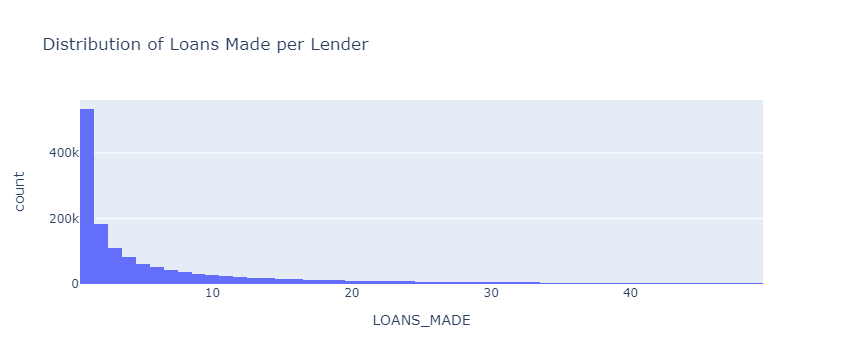

In [29]:
loans_made = px.histogram(data_frame=user_eda[(user_eda.LOANS_MADE < 50)], x="LOANS_MADE", nbins=50, title='Distribution of Loans Made per Lender')
#loans_made is a plotly interactive graph object - used the built in save to png feature 

#displaying saved png file from plotly graph to reduce notebook file size- https://stackoverflow.com/questions/11854847/how-can-i-display-an-image-from-a-file-in-jupyter-notebook
#from IPython.display import Image
Image(filename='../images/loans_made.png') 

In [30]:
user_eda.groupby('LENDER_COUNTRY_CODE')['LOANS_MADE'].size().to_frame().sort_values(by='LOANS_MADE',ascending = False).head(10)

,LOANS_MADE
LENDER_COUNTRY_CODE,
US,437174
CA,58534
AU,32020
GB,28686
DE,14577
NL,9872
SE,8709
NO,6453
FR,5256


#### <a name="sectorall"></a> All Loans by Sector

The majority of loans fall under agrictulural, food, and retail sectors. 

[Jump to the top of the page](#top)

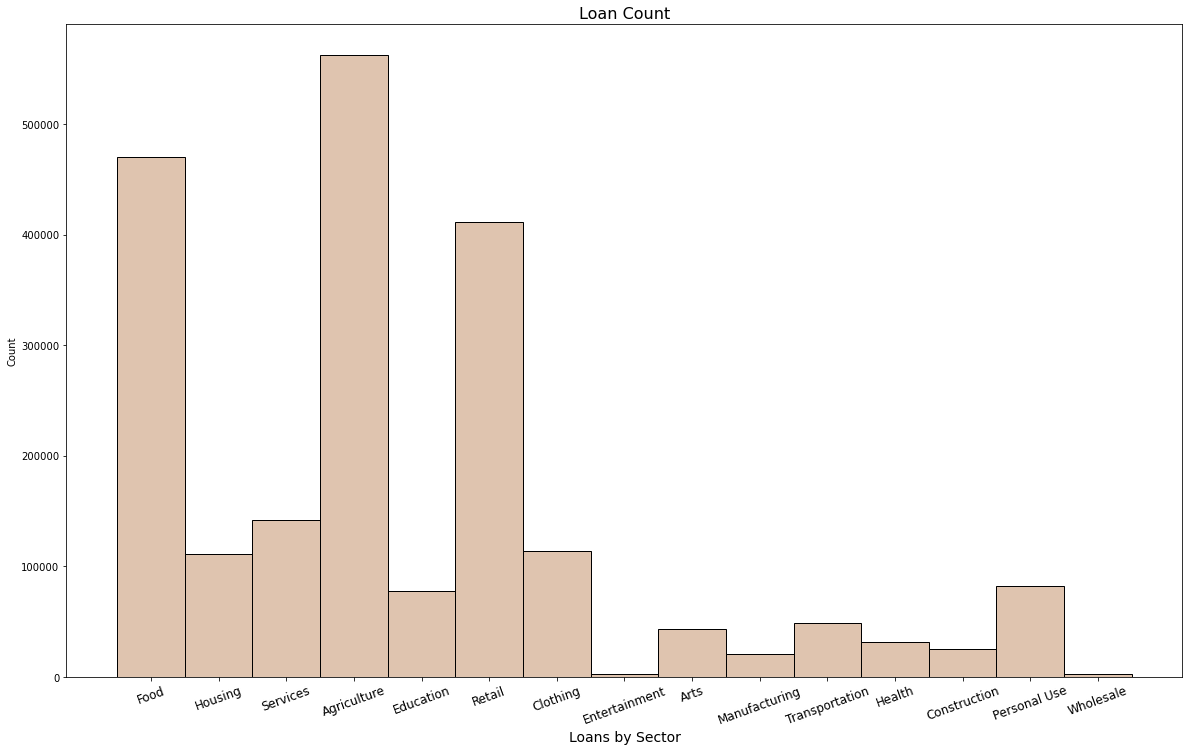

In [31]:
plt.figure(figsize=(20, 12))
sns.histplot(viz_loans_df['SECTOR_NAME'])
plt.xticks(rotation=20, fontsize=12)
plt.xlabel('Sector', fontsize=14)
plt.xticks(fontsize=12)
plt.xlabel('Loans by Sector', fontsize=14)
plt.title('Loan Count', fontsize=16);

#### <a name="sectorcountry"></a> Loans by Country and Sector (Top 10 Countries)

The vast majority of loans are made in the Philippines, most through the field partner Negros Women For Tomorrow Foundation, Inc. (NWTF).   


[Jump to the top of the page](#top)

In [32]:
top_ten['COUNTRY_NAME'].value_counts().to_frame()

,COUNTRY_NAME
Philippines,474699
Kenya,240598
Cambodia,102849
Peru,98600
El Salvador,89342
Uganda,76679
Tajikistan,73328
Ecuador,60784
Colombia,57057
Pakistan,56446


In [33]:
#This code inspired by: https://re-thought.com/pandas-value_counts/

ten_by_sector = top_ten.groupby('COUNTRY_NAME')['SECTOR_NAME'].value_counts().to_frame()

In [34]:
top_ten = top_ten.iloc[top_ten.groupby('COUNTRY_NAME').COUNTRY_NAME.transform('size').argsort(kind='mergesort')]

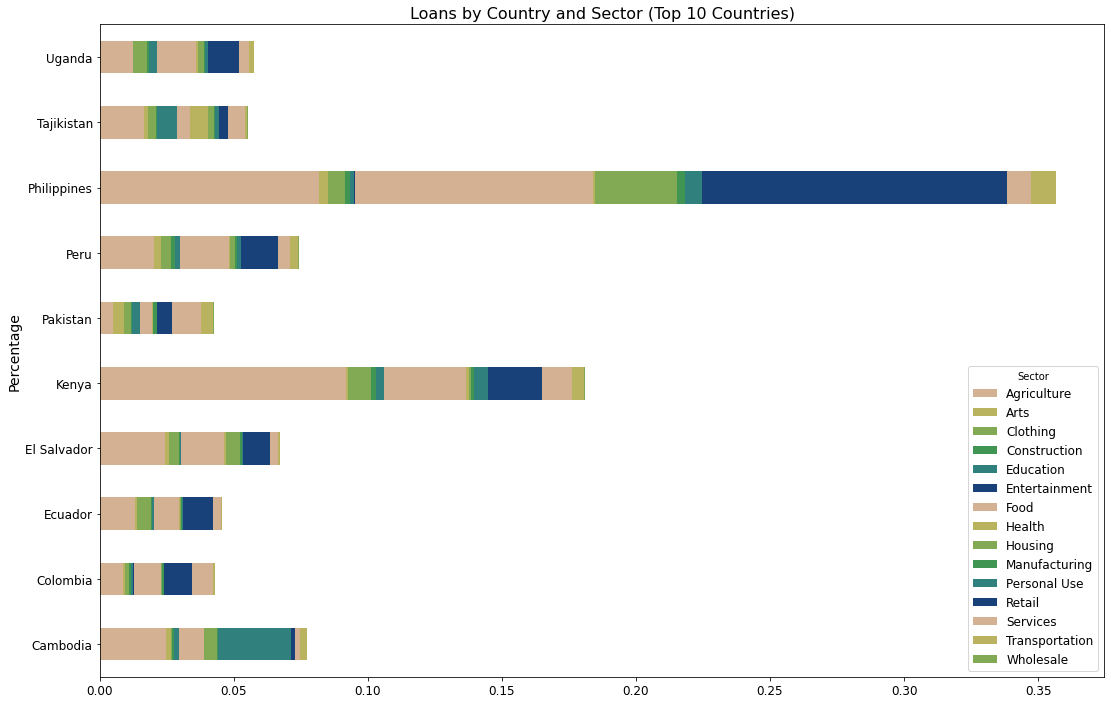

In [35]:
sector_country_crosstable=pd.crosstab(top_ten['COUNTRY_NAME'],top_ten['SECTOR_NAME'], normalize=True)

ax = sector_country_crosstable.plot(kind='barh', stacked=True, rot=0, figsize=(18, 12))
ax.legend(title='Sector', fontsize=12, )
plt.ylabel('Percentage', fontsize=14)
plt.ylabel('Country Name', fontsize=14)
plt.ylabel('Percentage')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Loans by Country and Sector (Top 10 Countries)', fontsize=16);



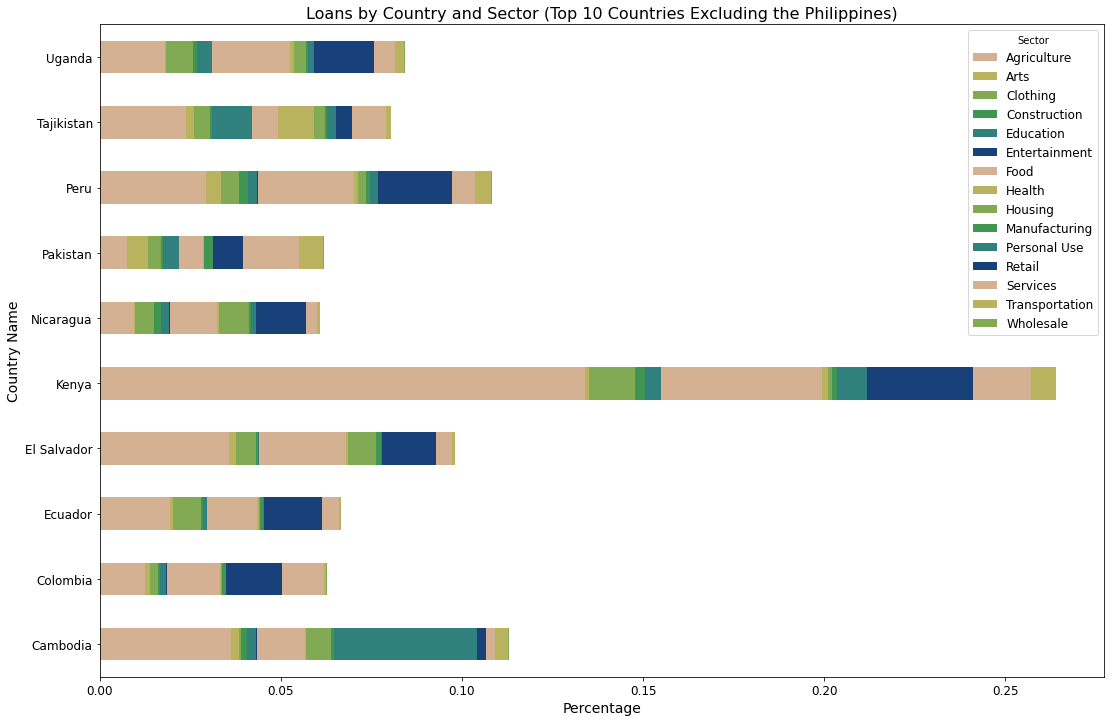

In [36]:
top_ten_no_phil = top_ten_no_phil.iloc[top_ten_no_phil.groupby('COUNTRY_NAME').COUNTRY_NAME.transform('size').argsort(kind='mergesort')]

sector_country_crosstable=pd.crosstab(top_ten_no_phil['COUNTRY_NAME'],top_ten_no_phil['SECTOR_NAME'], normalize=True)

ax = sector_country_crosstable.plot(kind='barh', stacked=True, rot=0, figsize=(18, 12))
ax.legend(title='Sector', fontsize=12, )
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Country Name', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Loans by Country and Sector (Top 10 Countries Excluding the Philippines)', fontsize=16);

#### <a name="entertainment"></a> Entertainment and Wholesale Sector Loans (Sectors with the Fewest Loans)

Loans to the Entertainment and Wholesale sectors have the lowest representation among all loans.

While the United States is underrepresented in overall loans, US based loans dominate the small Entertainment sector category, even surpassing the overall dominant Philippines. 

Pakistan, Uganda, Philipines, Kenya, and Cambodia dominate loans in the Wholesale sector, with activity being fairly evenly distributed between wholesale and goods distribution. 

In [37]:
entertainment_df = viz_loans_df[viz_loans_df['SECTOR_NAME'] == 'Entertainment']
wholesale_df = viz_loans_df[viz_loans_df['SECTOR_NAME'] == 'Wholesale']

In [38]:
entertainment_ten = get_ten_and_sort(entertainment_df)

In [39]:
wholesale_ten = get_ten_and_sort(wholesale_df)

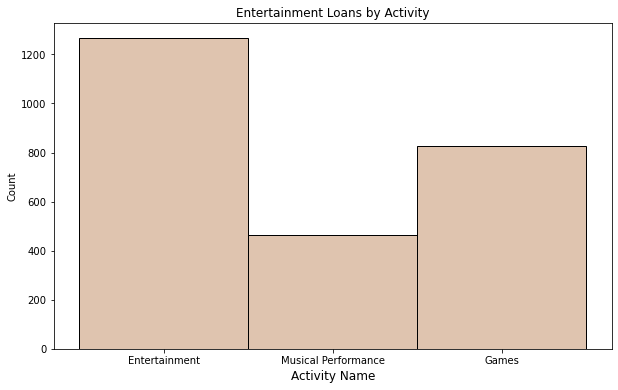

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(entertainment_df['ACTIVITY_NAME'])
plt.title('Entertainment Loans by Activity')
plt.xlabel('Activity Name', fontsize=12);

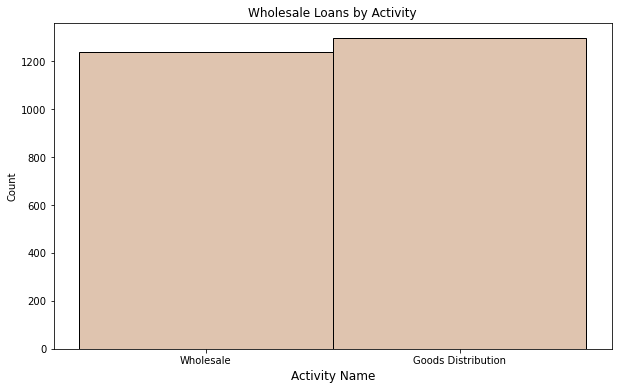

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(wholesale_df['ACTIVITY_NAME'])
plt.title('Wholesale Loans by Activity')
plt.xlabel('Activity Name', fontsize=12);

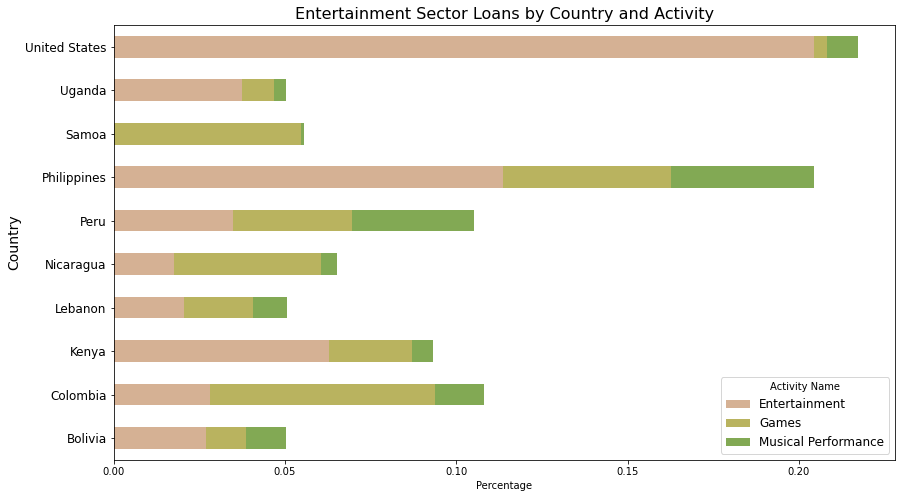

In [42]:
entertainment_crosstable=pd.crosstab(entertainment_ten['COUNTRY_NAME'],entertainment_ten['ACTIVITY_NAME'], normalize=True)

ax = entertainment_crosstable.plot(kind='barh', stacked=True, rot=0, figsize=(14, 8))
ax.legend(title='Activity Name', fontsize=12, )
plt.ylabel('Percentage', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Percentage')
plt.title('Entertainment Sector Loans by Country and Activity', fontsize=16);

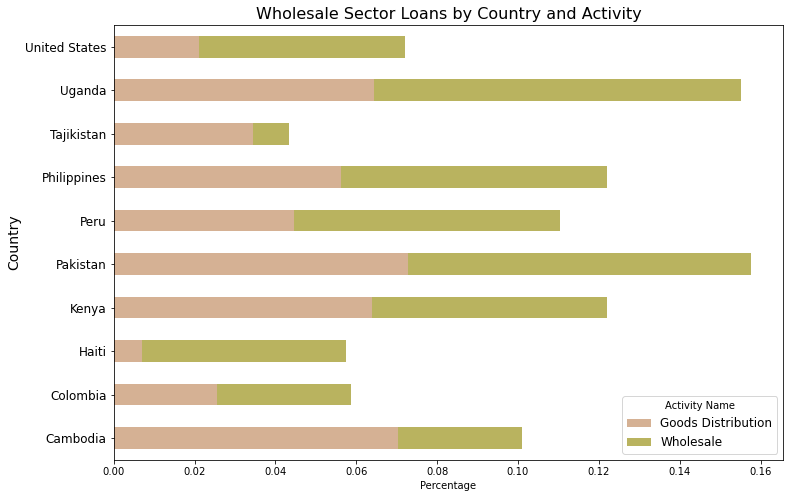

In [43]:
wholesale_crosstable=pd.crosstab(wholesale_ten['COUNTRY_NAME'],wholesale_ten['ACTIVITY_NAME'], normalize=True)

ax = wholesale_crosstable.plot(kind='barh', stacked=True, rot=0, figsize=(12, 8))
ax.legend(title='Activity Name', fontsize=12, )
plt.ylabel('Percentage', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Percentage')
plt.title('Wholesale Sector Loans by Country and Activity', fontsize=16);

#### <a name="agfood"></a> Agriculture and Food Sector Loans (Sectors with the Most Loans)

Food production and sale and Farming dominate these top two sectors. 

The vast majority of Agricultural Sector loans are associated with Kenya (most activity related to farming supplies), followed closely by the Philippines (most activity related to pigs). 

Food sector loans are dominated by the Philippines, follwed by Kenya, Uganda, and Peru.

In [44]:
ag_df = viz_loans_df[viz_loans_df['SECTOR_NAME'] == 'Agriculture']
food_df = viz_loans_df[viz_loans_df['SECTOR_NAME'] == 'Food']

In [45]:
ag_ten = get_ten_and_sort(ag_df)
food_ten = get_ten_and_sort(food_df)

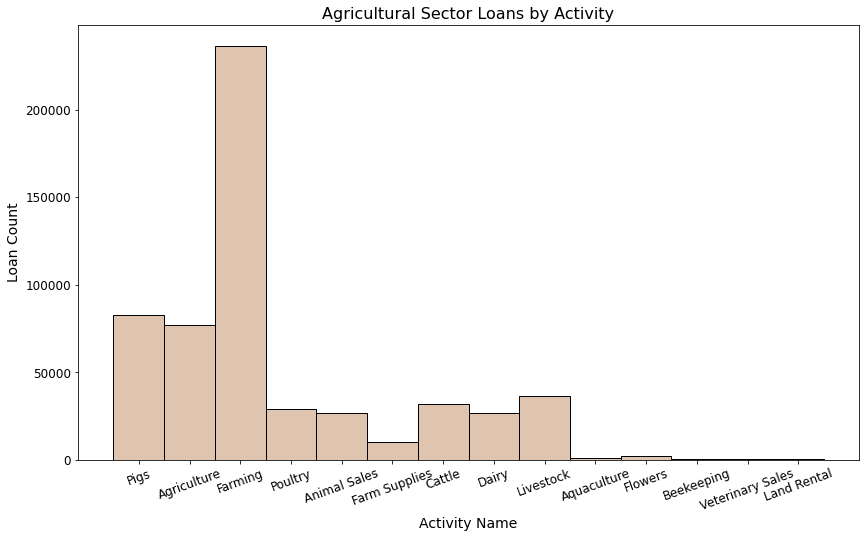

In [46]:
plt.figure(figsize=(14, 8))
sns.histplot(ag_df['ACTIVITY_NAME'])
plt.title('Agricultural Sector Loans by Activity', fontsize=16)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Activity Name', fontsize=14)
plt.ylabel('Loan Count', fontsize=14);

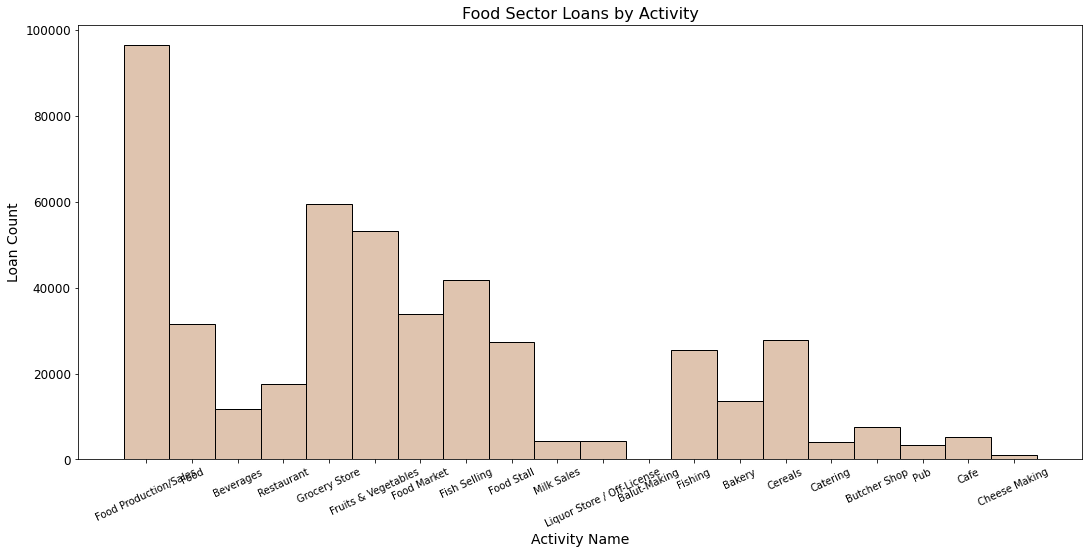

In [47]:
plt.figure(figsize=(18, 8))
sns.histplot(food_df['ACTIVITY_NAME'])
plt.title('Food Sector Loans by Activity', fontsize=16)
plt.xticks(rotation=25, fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel('Activity Name', fontsize=14)
plt.ylabel('Loan Count', fontsize=14);

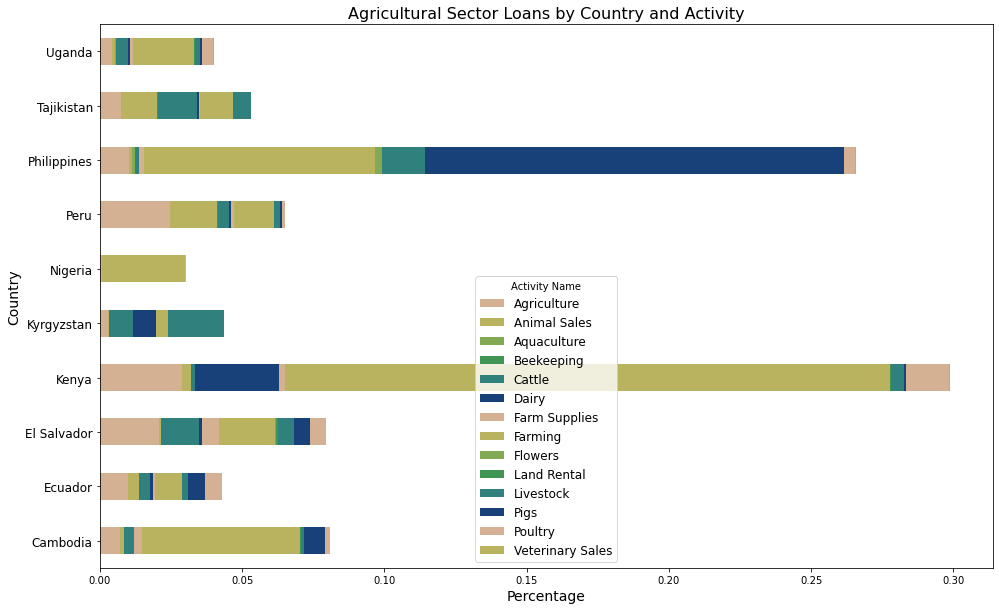

In [48]:
ag_crosstable=pd.crosstab(ag_ten['COUNTRY_NAME'],ag_ten['ACTIVITY_NAME'], normalize=True)

ax = ag_crosstable.plot(kind='barh', stacked=True, rot=0, figsize=(16, 10))
ax.legend(title='Activity Name', fontsize=12, loc='best')
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Agricultural Sector Loans by Country and Activity', fontsize=16);

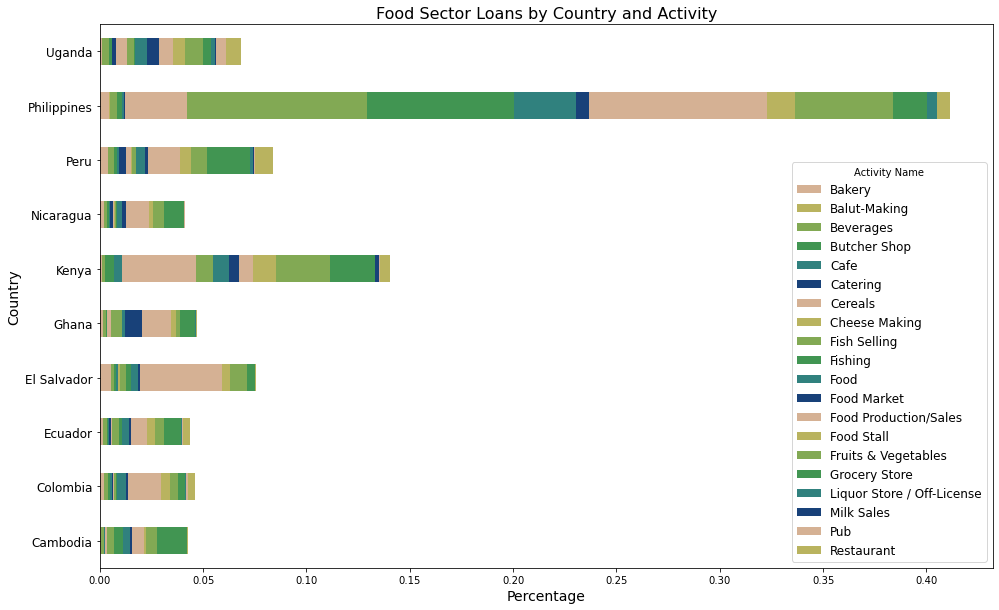

In [49]:
food_crosstable=pd.crosstab(food_ten['COUNTRY_NAME'],food_ten['ACTIVITY_NAME'], normalize=True)

ax = food_crosstable.plot(kind='barh', stacked=True, rot=0, figsize=(16, 10))
ax.legend(title='Activity Name', fontsize=12, )
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Food Sector Loans by Country and Activity', fontsize=16);

### <a name="genderanalysis"></a> Gender Analysis

[Jump to the top of the page](#top)

#### Individual vs. Group Loans by Gender

66% of all Kiva loans go to individual women, vs. individual men(20%) and groups(13%). 

In [50]:
#Creating column to evaluate composition of entrepreneurs: groups vs. solo, by gender. 

def a(df):
    if df['BORROWER_GENDERS'] == 'male':
        return 'male'
    elif df['BORROWER_GENDERS'] == 'female':
        return 'female'
    else:
        return 'groups'
loans_df['BORROWER_COMPOSITION'] = loans_df.apply(a, axis=1)

In [51]:
loans_df['BORROWER_COMPOSITION'].value_counts()

female    1416883
male       436316
groups     333919
Name: BORROWER_COMPOSITION, dtype: int64

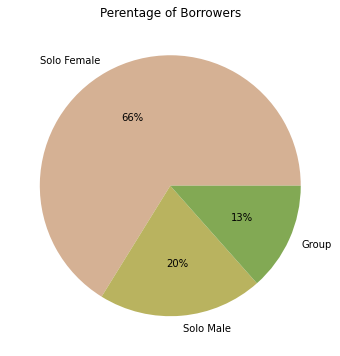

In [52]:
#reference for seaborn pie charts : https://www.dataforeverybody.com/matplotlib-seaborn-pie-charts/
data = [1417379, 436449, 287950]
labels = ['Solo Female', 'Solo Male', 'Group']

plt.figure(figsize=(6,6))
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.title('Perentage of Borrowers')
plt.show()

#### <a name="10female"></a> The ten countries representing the highest percentage of loans to female operated endeavors. 

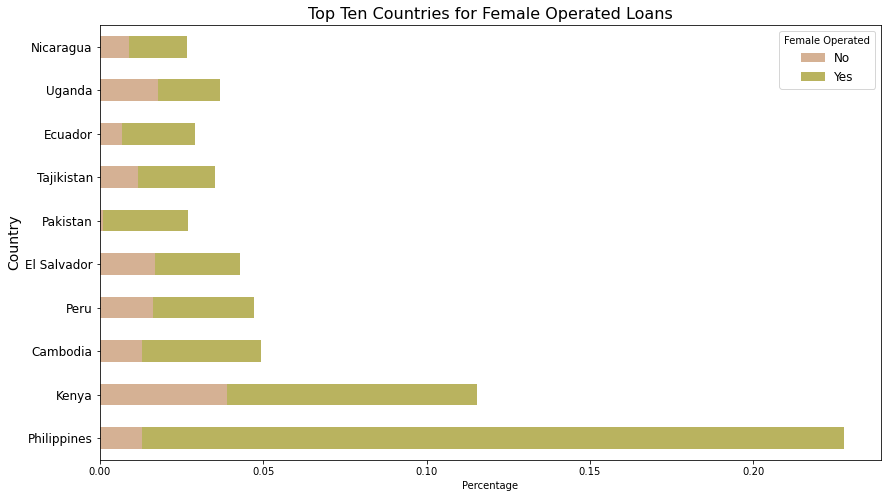

In [53]:
gender_country_crosstable=pd.crosstab(countries_with_most_loans['COUNTRY_NAME'],countries_with_most_loans['FEMALE_OPERATED'], normalize=True).sort_values(by=1, ascending=False)
top_gender_country = gender_country_crosstable[:10]

ax = top_gender_country.plot(kind='barh', stacked=True, rot=0, figsize=(14, 8))
ax.legend(title='Female Operated', labels=['No', 'Yes'], fontsize=12, )
plt.ylabel('Country Name', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Percentage')
plt.title('Top Ten Countries for Female Operated Loans', fontsize=16);



### <a name="sectorfemale"></a> Female operated endeavors by sector.

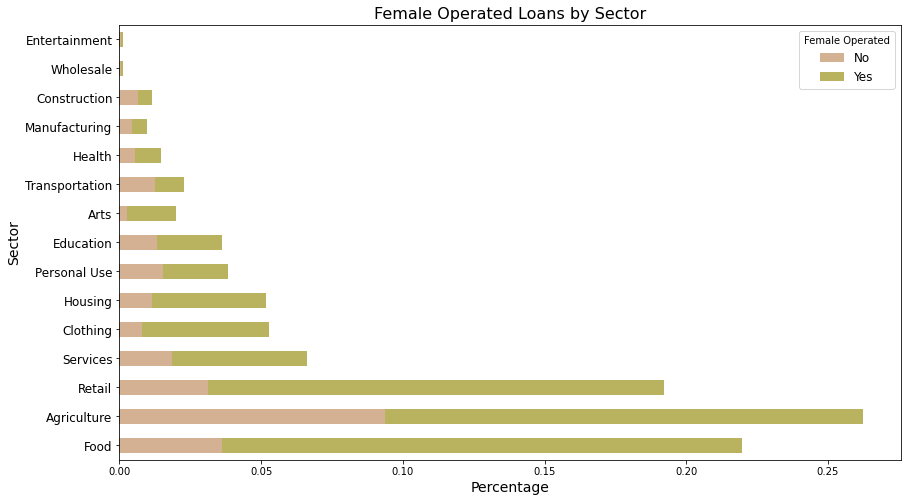

In [54]:
sector_gender_crosstable=pd.crosstab(viz_loans_df['SECTOR_NAME'],viz_loans_df['FEMALE_OPERATED'], normalize=True).sort_values(by=1, ascending=False)

ax = sector_gender_crosstable.plot(kind='barh', stacked=True, rot=0, figsize=(14, 8))
ax.legend(title='Female Operated', labels=['No', 'Yes'], fontsize=12, )
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Sector', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Female Operated Loans by Sector', fontsize=16);


### <a name="women"></a> Loans in Countries Ranked Lowest for Women's Peace and Security

According to the Georgetown Institute for Women, Peace and Security's index, Afghanistan, Syria, Yemen, Pakistan, Iraq, South Sudan, Chad, Democratic Republic of Congo, Sudan, and Sierra Leone rank the lowest for women's peace and security. Of these countries, South Sudan, Sierra Leone, Iraq, Pakistan, Yemen, Democratic Republic of Congo, and Afghanistan are listed among Kiva loans. We look specifically at loans to these countries below.

For comparison, the highest ranked countries for women's peace and security are Norway, Finland, Iceland, Luxembourg, Switzerland, Denmark, Sweden, Austria, United Kingdom, Netherlands. None of these countries are represented in the Kiva dataset. 

Source: https://giwps.georgetown.edu/the-index/

In [55]:
#checking for inclusion of lowest ranked countries in loans dataframe.

countries_low_women_security_check = ['Afghanistan', 'Syria', 'Yemen', 'Pakistan', 'Iraq', 'South Sudan', 'Chad',
                                'The Democratic Republic of the Congo','Sudan', 'Sierra Leone']
names = []
for name in viz_loans_df['COUNTRY_NAME']:
    if name in countries_low_women_security_check:
        names.append(name)
lowranked_women_security = list(set(names))
lowranked_women_security    

['Sierra Leone',
 'Yemen',
 'South Sudan',
 'Afghanistan',
 'Pakistan',
 'The Democratic Republic of the Congo',
 'Iraq']

In [56]:
lws_df = viz_loans_df[viz_loans_df.COUNTRY_NAME.isin(lowranked_women_security)]

In [57]:
#checking for inclusion of highest ranked countries in loans dataframe. None are included.

countries_high_women_security_check = ['Norway', 'Finland', 'Iceland', 'Luxembourg', 'Switzerland', 'Denmark',
                                       'Sweden', 'Austria', 'United Kingdom', 'Netherlands']
names = []
for name in viz_loans_df['COUNTRY_NAME']:
    if name in countries_high_women_security_check:
        names.append(name)
highranked_women_security = list(set(names))

highranked_women_security   

[]

While Agriculture and Food related loans dominate the overall dataset, when looking at only loans to these countries ranked low for women's peace and security, loans for Food, Retail, and Services are the most common. 

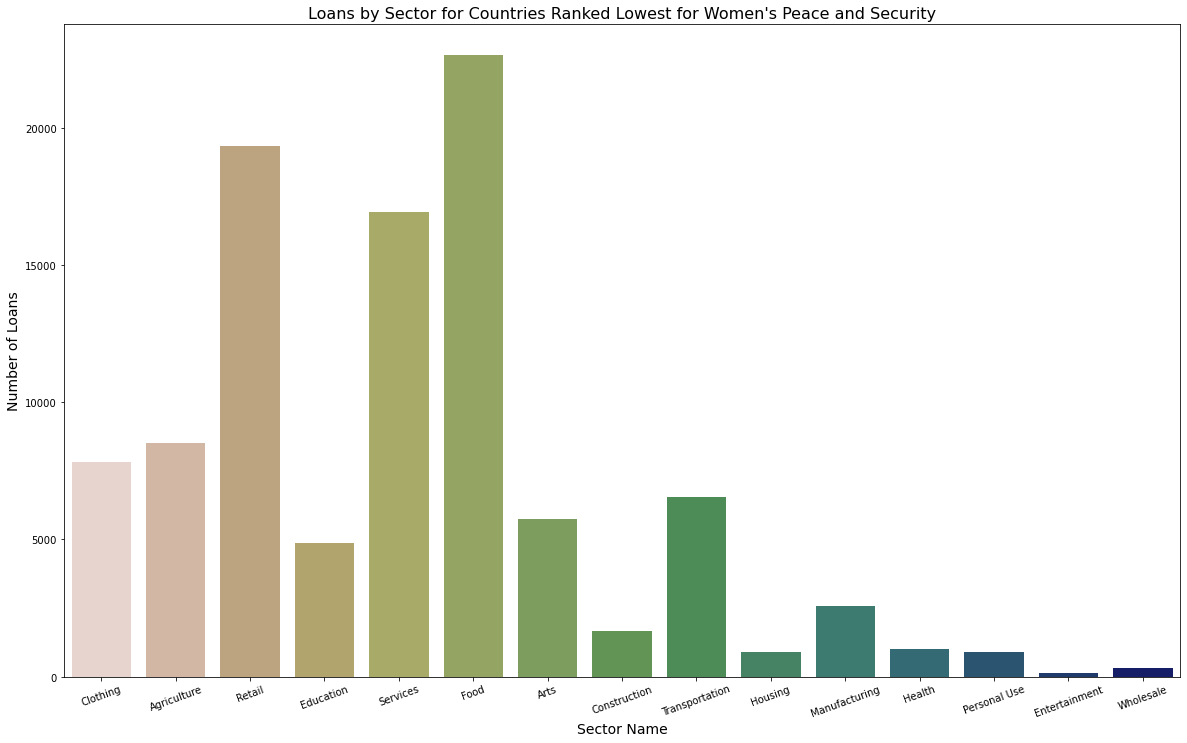

In [58]:
plt.figure(figsize=(20, 12))
ax = sns.countplot(x="SECTOR_NAME", data=lws_df, palette="gist_earth_r")
plt.title('Loans by Sector for Countries Ranked Lowest for Women\'s Peace and Security', fontsize=16)
plt.xticks(rotation=20)
plt.xlabel('Sector Name', fontsize=14)
plt.ylabel('Number of Loans', fontsize=14);

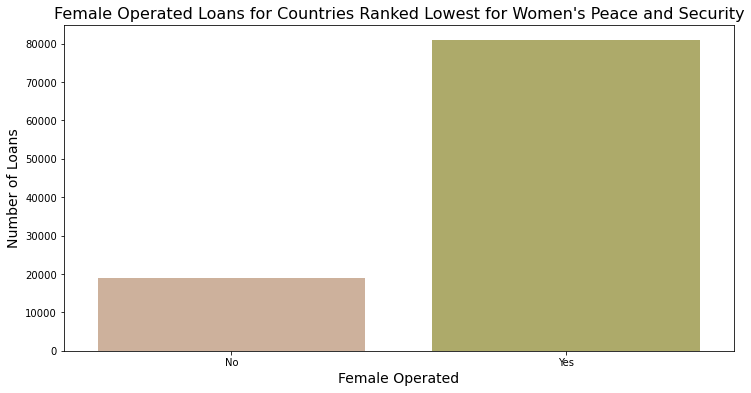

In [59]:
#I consulated this stackoverflow for guidance on relabeling xticks: https://stackoverflow.com/questions/11244514/modify-tick-label-text

plt.figure(figsize=(12, 6))
ax = sns.countplot(x="FEMALE_OPERATED", data=lws_df)
plt.title('Female Operated Loans for Countries Ranked Lowest for Women\'s Peace and Security', fontsize=16)

x1 = [0, 1]
xlabels = ['No', 'Yes']

ax.set_xticks(x1)
ax.set_xticklabels(xlabels, minor=False)

plt.xlabel('Female Operated', fontsize=14)
plt.ylabel('Number of Loans', fontsize=14);

### <a name="time"></a> Loans Over Time

The number of loans funded per year shows an upward trend from 2006-2018. There appears to be a slight decrease in 2018, followed by a sharp decrease that appears to precede the onset of the COVID-19 pandemic.

[Jump to the top of the page](#top)

In [76]:
# setting posted_time as datetime object and index
time_df = viz_loans_df.copy()
time_df['POSTED_TIME'] = pd.to_datetime(time_df['POSTED_TIME'], utc=True)
time_df.set_index('POSTED_TIME', inplace=True)
time_df.sort_index(inplace=True)
time_df.head()

,LOAN_ID,ORIGINAL_LANGUAGE,LOAN_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,TOWN_NAME,PARTNER_ID,DISBURSE_TIME,RAISED_TIME,NUM_LENDERS_TOTAL,TAGS,BORROWER_GENDERS,FEMALE_OPERATED
POSTED_TIME,,,,,,,,,,,,,,
2006-04-16 00:00:00+00:00,219,English,425.0,Home Products Sales,Retail,Honduras,Danli,5,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6,NaN,[female],1
2006-04-16 00:00:00+00:00,253,English,300.0,Printing,Services,Kenya,Ongata Rongai,6,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,4,NaN,[female],1
2006-04-16 00:00:00+00:00,196,English,600.0,Cheese Making,Food,Honduras,Siguatepeque,5,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,4,NaN,[female],1
2006-04-16 00:00:00+00:00,290,English,450.0,Cattle,Agriculture,Kenya,Isinya,6,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,4,NaN,[female],1
2006-04-16 00:00:00+00:00,255,English,300.0,Used Clothing,Clothing,Kenya,Ongata Rongai,6,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,2,NaN,[female],1


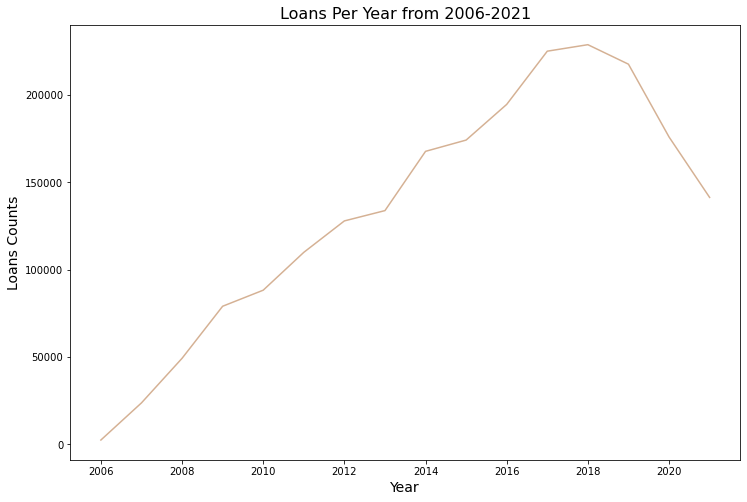

In [77]:
plt.figure(figsize=(12, 8))
plt.plot(time_df['COUNTRY_NAME'].groupby([time_df.index.year]).agg('count'))
plt.title('Loans Per Year from 2006-2021', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Loans Counts', fontsize=14);

In [74]:
#Explore trends by country using the time_trend_by_country_formula

def time_trend_by_country(country_name):
    df = time_df[time_df['COUNTRY_NAME'] == country_name]
    plt.figure(figsize=(12, 8))
    plt.plot(df['COUNTRY_NAME'].groupby([df.index.year]).agg('count'))
    plt.title(f'Loans Per Year from 2006-2021 in {country_name}', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Loans Counts', fontsize=14);

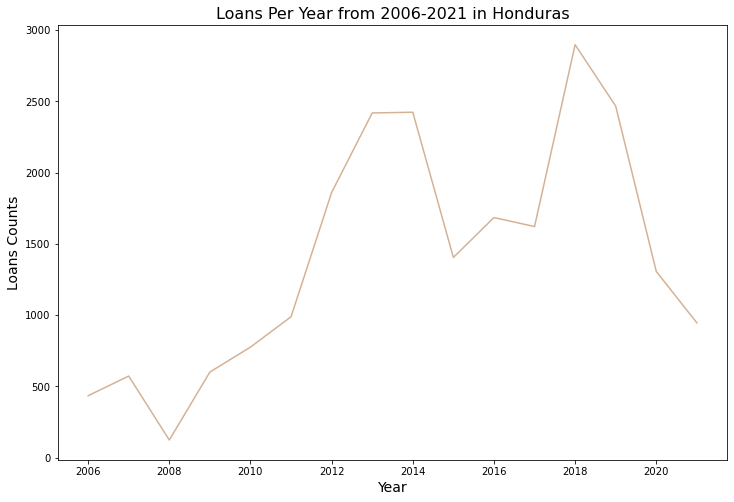

In [75]:
time_trend_by_country('Honduras')

#### <a name='streamlit'></a>Creating CSV for Streamlit Visualizations Deployment

[Jump to the top of the page](#top)

In [ ]:
# create stratified dataframe for streamlit deployment
# code from statology: https://www.statology.org/stratified-sampling-pandas/
N=200000
streamlit_df = viz_loans_df.groupby('COUNTRY_NAME', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(viz_loans_df))))).sample(frac=1).reset_index(drop=True)

In [ ]:
streamlit_df.set_index('POSTED_TIME', inplace=True)
streamlit_df.sort_index(inplace=True)

In [ ]:
streamlit_df.to_csv('./streamlit_df.csv')